In [1]:
%matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt

# NuScenes api
from nuscenes.nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='/home/samliu/code/radar-image-fusion/nuscenes_dataset/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.474 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
for index_scene, scene_dict in enumerate(nusc.scene):
    print(scene_dict['name'])

scene-0061
scene-0103
scene-0553
scene-0655
scene-0757
scene-0796
scene-0916
scene-1077
scene-1094
scene-1100


In [3]:
# label categories
nusc.list_categories()

Category stats for split v1.0-mini:
human.pedestrian.adult      n= 4765, width= 0.68±0.11, len= 0.73±0.17, height= 1.76±0.12, lw_aspect= 1.08±0.23
human.pedestrian.child      n=   46, width= 0.46±0.08, len= 0.45±0.09, height= 1.37±0.06, lw_aspect= 0.97±0.05
human.pedestrian.constructi n=  193, width= 0.69±0.07, len= 0.74±0.12, height= 1.78±0.05, lw_aspect= 1.07±0.16
human.pedestrian.personal_m n=   25, width= 0.83±0.00, len= 1.28±0.00, height= 1.87±0.00, lw_aspect= 1.55±0.00
human.pedestrian.police_off n=   11, width= 0.59±0.00, len= 0.47±0.00, height= 1.81±0.00, lw_aspect= 0.80±0.00
movable_object.barrier      n= 2323, width= 2.32±0.49, len= 0.61±0.11, height= 1.06±0.10, lw_aspect= 0.28±0.09
movable_object.debris       n=   13, width= 0.43±0.00, len= 1.43±0.00, height= 0.46±0.00, lw_aspect= 3.35±0.00
movable_object.pushable_pul n=   82, width= 0.51±0.06, len= 0.79±0.10, height= 1.04±0.20, lw_aspect= 1.55±0.18
movable_object.trafficcone  n= 1378, width= 0.47±0.14, len= 0.45±0.07, heigh

In [4]:
# Traverse all scenes and samples, and show the scene description
for index_scene, scene_dict in enumerate(nusc.scene):
    
    # Start traverse from first token
    next_token = scene_dict['first_sample_token']
    print("scene index:{}, description: {}".format(index_scene, scene_dict['description']))
    
    while next_token != "":
        my_sample = nusc.get('sample', next_token)
        
        # traverse all front radar samples
        radar_pcd_path, boxes_radar_view, _ = nusc.get_sample_data(my_sample['data']['RADAR_FRONT'])
        # traverse all front camera samples
        image_path, boxes_cam_view, camera_intrinsic = nusc.get_sample_data(my_sample['data']['CAM_FRONT'])
        
        # Point to next token
        next_token = my_sample['next']

scene index:0, description: Parked truck, construction, intersection, turn left, following a van
scene index:1, description: Many peds right, wait for turning car, long bike rack left, cyclist
scene index:2, description: Wait at intersection, bicycle, large truck, peds crossing crosswalk, ped with stroller
scene index:3, description: Parking lot, parked cars, jaywalker, bendy bus, gardening vehicles
scene index:4, description: Arrive at busy intersection, bus, wait at intersection, bicycle, peds
scene index:5, description: Scooter, peds on sidewalk, bus, cars, truck, fake construction worker, bicycle, cross intersection, car overtaking us
scene index:6, description: Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle
scene index:7, description: Night, big street, bus stop, high speed, construction vehicle
scene index:8, description: Night, after rain, many peds, PMD, ped with bag, jaywalker, truck, scooter
scene index:9, description: Night, pe

## Start to extract radar data

In [5]:
from nuscenes.utils.data_classes import RadarPointCloud
## Disable radar filter
RadarPointCloud.disable_filters()

##Enable radar filter
# RadarPointCloud.default_filters()

In [6]:
my_sample = nusc.sample[0]    # Another way to get sample

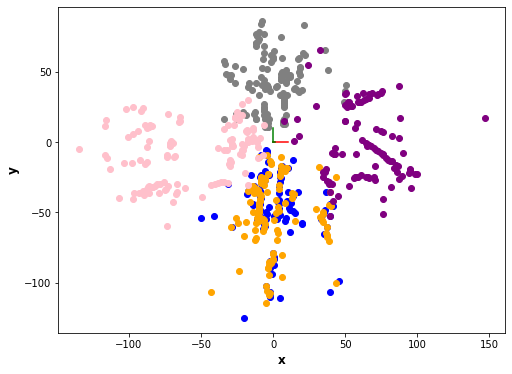

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xlabel("x", fontsize=12, fontweight='bold')
ax.set_ylabel("y", fontsize=12, fontweight='bold')
ax.plot((0, 10), (0, 0), (0, 0), c='red')
ax.plot((0, 0), (0, 10), (0, 0), c='green')

# Sweep parameter
nsweeps = 1

my_sample = my_sample
reference_channel = 'LIDAR_TOP'

channel = 'RADAR_FRONT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='gray')

channel = 'RADAR_BACK_RIGHT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='blue')

channel = 'RADAR_BACK_LEFT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='orange')

channel = 'RADAR_FRONT_RIGHT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='purple')

channel = 'RADAR_FRONT_LEFT'
points, times = RadarPointCloud.from_file_multisweep(nusc, my_sample, channel, reference_channel, nsweeps)
ax.scatter(points.points[0, :], points.points[1, :], marker='o', c='pink')

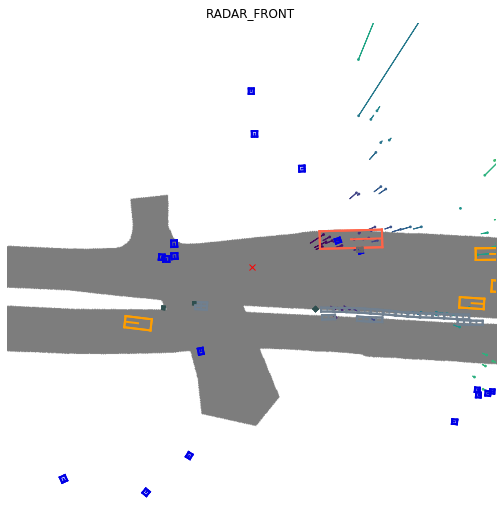

In [8]:
nusc.render_sample_data(my_sample['data']['RADAR_FRONT'], nsweeps=1, underlay_map=True)

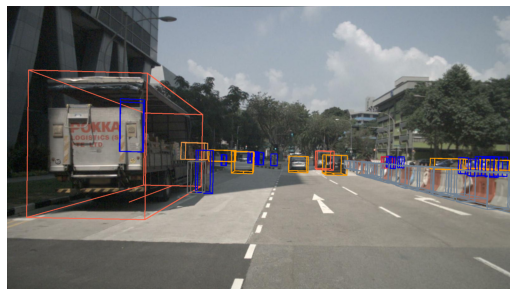

In [9]:
# 投射物件框在影像上
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
fig.canvas.set_window_title('ss')
ax.axis('off')

impath, boxes, camera_intrinsic = nusc.get_sample_data(my_sample['data']['CAM_FRONT'])
im = cv2.imread(impath)
for idx, box in enumerate(boxes):
    c = nusc.colormap[box.name]

    box.render_cv2(im, view=camera_intrinsic, normalize=True, colors=(c, c, c))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

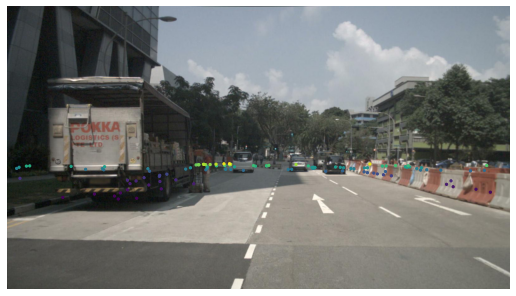

In [10]:
# 投射雷達點在影像上
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='RADAR_FRONT')

In [11]:
# 在 lidar-top frame上畫出每一個annotation 的位置
# for i in range(len(my_sample['anns'])):
#     nusc.render_annotation(my_sample['anns'][i])

In [12]:
# 迷幻眩光 scene
my_scene_token = nusc.field2token('scene', 'name', 'scene-1100')[0]
nusc.render_scene_channel(my_scene_token, 'CAM_FRONT', imsize=(1280, 720))

## accumulate radar data manually (deprecated)

In [13]:
# sample_rec = my_sample
# channel = 'RADAR_FRONT'

# ref_sd_token = sample_rec['data'][channel]
# ref_sd_rec = nusc.get('sample_data', ref_sd_token)

# sample_data_token = sample_rec['data'][channel]
# current_sd_rec = nusc.get('sample_data', sample_data_token)

# nsweeps = 10
# for _ in range(nsweeps):
#     # Load up the pointcloud and remove points close to the sensor.
#     current_pc = RadarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))
#     current_pc.remove_close(1.0)
    
#     if current_sd_rec['prev'] == '':
#         break
#     else:
#         current_sd_rec = nusc.get('sample_data', current_sd_rec['prev'])
